In [29]:
!pip install -q transformers datasets scikit-learn torch joblib


In [6]:
import os, random, joblib, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, cohen_kappa_score, 
                             top_k_accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [7]:
print("="*50)
print("GPU CHECK")
print("="*50)
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("⚠️ WARNING: No GPU detected!")
print("="*50)

GPU CHECK
CUDA available: True
Device count: 1
Current device: 0
Device name: Tesla P100-PCIE-16GB
CUDA version: 12.4


In [9]:
# Data paths
DATA_CSV = "/kaggle/input/bayyin-data/bayyin_dataset.csv"
TEXT_COL = "Sentence"
LABEL_COL = "Readability_Level"
ID_COL = "ID"

NUMERIC_COLS = ["Word_Count", "Word", "Lex", "D3Tok", "D3Lex"]
CATEGORICAL_COLS = ["Document", "Source", "Book", "Author", "Domain", 
                    "Text_Class", "Dataset_Source"]

# Model hyperparameters
BATCH_SIZE = 16
EPOCHS = 5
NUM_CLASSES = 6
LSTM_HIDDEN = 256  # BiLSTM hidden dimension as per research
DROPOUT = 0.3
WEIGHT_DECAY = 1e-2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
OUTPUT_DIR = "./bilstm_comparison"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Embedding-specific parameters
ARABERT_MODEL = "aubmindlab/bert-base-arabertv2"
CAMELBERT_MODEL = "CAMeL-Lab/bert-base-arabic-camelbert-msa"
MAX_LEN = 20  # For transformer models
TFIDF_MAX_FEATURES = 5000
WORD2VEC_DIM = 300

# Learning rates
BERT_LR = 2e-5
HEAD_LR = 1e-3
STATIC_LR = 1e-3


In [12]:
def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def normalize_arabic(text):
    """Basic Arabic text normalization"""
    if not isinstance(text, str):
        return ""
    import re
    text = text.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا")
    text = text.replace("ى", "ي")
    text = re.sub("[ًٌٍَُِّْـ]", "", text)  # Remove diacritics
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [17]:
set_seed(SEED)

# Load data
df = pd.read_csv(DATA_CSV)
df[TEXT_COL] = df[TEXT_COL].astype(str).apply(normalize_arabic)

# Adjust labels to 0-5 range
if df[LABEL_COL].min() == 1:
    df[LABEL_COL] = df[LABEL_COL] - 1
assert df[LABEL_COL].min() >= 0 and df[LABEL_COL].max() < NUM_CLASSES

# Process numeric features
for col in NUMERIC_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[NUMERIC_COLS] = df[NUMERIC_COLS].fillna(0.0)
scaler = StandardScaler()
df[NUMERIC_COLS] = scaler.fit_transform(df[NUMERIC_COLS])

# Process categorical features
label_encoders = {}
for c in CATEGORICAL_COLS:
    df[c] = df[c].fillna("UNKNOWN").astype(str)
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])
    label_encoders[c] = le

# Save encoders
joblib.dump({"scaler": scaler, "label_encoders": label_encoders}, 
            os.path.join(OUTPUT_DIR, "meta_encoders.joblib"))

# Train/Val/Test split
train_val_df, test_df = train_test_split(df, test_size=0.2, 
                                          stratify=df[LABEL_COL], random_state=SEED)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, 
                                     stratify=train_val_df[LABEL_COL], 
                                     random_state=SEED)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"Total: {len(train_df)+len(val_df)+len(test_df)} ")

Train: 33415, Val: 3713, Test: 9282
Total: 46410 


In [18]:
# --- TF-IDF Embedding ---
print("Creating TF-IDF embeddings...")
tfidf_vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, 
                                   ngram_range=(1, 2))
train_tfidf = tfidf_vectorizer.fit_transform(train_df[TEXT_COL]).toarray()
val_tfidf = tfidf_vectorizer.transform(val_df[TEXT_COL]).toarray()
test_tfidf = tfidf_vectorizer.transform(test_df[TEXT_COL]).toarray()
joblib.dump(tfidf_vectorizer, os.path.join(OUTPUT_DIR, "tfidf_vectorizer.joblib"))
print(f"   TF-IDF dimension: {train_tfidf.shape[1]}")

Creating TF-IDF embeddings...
   TF-IDF dimension: 5000


In [20]:
print("Training Word2Vec model...")
train_sentences = [simple_preprocess(text) for text in train_df[TEXT_COL]]
w2v_model = Word2Vec(sentences=train_sentences, vector_size=WORD2VEC_DIM, 
                     window=5, min_count=2, workers=4, epochs=10, seed=SEED)
w2v_model.save(os.path.join(OUTPUT_DIR, "word2vec.model"))

def text_to_w2v(text, model, dim=WORD2VEC_DIM):
    """Convert text to Word2Vec average embedding"""
    tokens = simple_preprocess(text)
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

train_w2v = np.array([text_to_w2v(text, w2v_model) for text in train_df[TEXT_COL]])
val_w2v = np.array([text_to_w2v(text, w2v_model) for text in val_df[TEXT_COL]])
test_w2v = np.array([text_to_w2v(text, w2v_model) for text in test_df[TEXT_COL]])
print(f"   Word2Vec dimension: {WORD2VEC_DIM}")

Training Word2Vec model...
   Word2Vec dimension: 300


In [21]:
print("Loading AraBERT tokenizer...")
arabert_tokenizer = AutoTokenizer.from_pretrained(ARABERT_MODEL, use_fast=True)

Loading AraBERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [22]:
print("Loading CamelBERT tokenizer...")
camelbert_tokenizer = AutoTokenizer.from_pretrained(CAMELBERT_MODEL, use_fast=True)


Loading CamelBERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [23]:
class StaticEmbeddingDataset(Dataset):
    """Dataset for TF-IDF and Word2Vec embeddings"""
    def __init__(self, embeddings, df, label_col, numeric_cols, categorical_cols):
        self.embeddings = embeddings
        self.labels = df[label_col].astype(int).values
        self.numeric = df[numeric_cols].values.astype(np.float32)
        self.categorical = df[categorical_cols].values.astype(np.int64)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            "embedding": torch.tensor(self.embeddings[idx], dtype=torch.float32),
            "numeric": torch.tensor(self.numeric[idx], dtype=torch.float32),
            "categorical": torch.tensor(self.categorical[idx], dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

class TransformerDataset(Dataset):
    """Dataset for transformer-based embeddings"""
    def __init__(self, df, tokenizer, text_col, label_col, numeric_cols, 
                 categorical_cols, max_len):
        self.texts = df[text_col].values
        self.labels = df[label_col].astype(int).values
        self.numeric = df[numeric_cols].values.astype(np.float32)
        self.categorical = df[categorical_cols].values.astype(np.int64)
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], padding='max_length', 
                            truncation=True, max_length=self.max_len, 
                            return_tensors='pt')
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "numeric": torch.tensor(self.numeric[idx], dtype=torch.float32),
            "categorical": torch.tensor(self.categorical[idx], dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [24]:
class BiLSTMWithMeta(nn.Module):
    """
    BiLSTM with metadata as described in the research paper.
    Works with any input embedding (static or contextual).
    """
    def __init__(self, input_dim, categorical_cardinalities, num_numeric,
                 lstm_hidden=256, meta_proj_dim=128, num_classes=6, dropout=0.3,
                 use_bert=False, bert_model_name=None):
        super().__init__()
        
        self.use_bert = use_bert
        
        # Optional BERT encoder
        if use_bert and bert_model_name:
            self.bert = AutoModel.from_pretrained(bert_model_name)
            input_dim = self.bert.config.hidden_size
        else:
            self.bert = None
        
        # BiLSTM layer (as per research)
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden,
                           num_layers=1, batch_first=True, bidirectional=True)
        
        # Metadata embeddings for categorical features
        self.cat_names = list(categorical_cardinalities.keys())
        self.cat_embeddings = nn.ModuleDict()
        total_cat_emb_dim = 0
        for name, card in categorical_cardinalities.items():
            emb_dim = min(50, max(4, int(card**0.5)))
            self.cat_embeddings[name] = nn.Embedding(card, emb_dim)
            total_cat_emb_dim += emb_dim
        
        # Metadata projection
        self.meta_proj = nn.Sequential(
            nn.Linear(total_cat_emb_dim + num_numeric, meta_proj_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Final classifier (BiLSTM output + metadata)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2 + meta_proj_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, numeric_meta, categorical_meta, attention_mask=None):
        # Process text through BERT if available
        if self.use_bert:
            bert_out = self.bert(input_ids=x, attention_mask=attention_mask)
            x = bert_out.last_hidden_state
        else:
            # For static embeddings, add sequence dimension
            if len(x.shape) == 2:
                x = x.unsqueeze(1)
        
        # BiLSTM processing
        lstm_out, _ = self.lstm(x)
        pooled = lstm_out.mean(dim=1) if self.use_bert else lstm_out.squeeze(1)
        
        # Process metadata
        cat_embs = [self.cat_embeddings[name](categorical_meta[:, i]) 
                   for i, name in enumerate(self.cat_names)]
        cat_concat = torch.cat(cat_embs, dim=1) if cat_embs else \
                     torch.zeros(numeric_meta.size(0), 0, device=numeric_meta.device)
        
        meta_concat = torch.cat([numeric_meta, cat_concat], dim=1)
        meta_vec = self.meta_proj(meta_concat)
        
        # Combine and classify
        fused = torch.cat([pooled, meta_vec], dim=1)
        fused = self.dropout(fused)
        return self.classifier(fused)


In [25]:
def train_epoch(model, loader, optimizer, scheduler, device, is_transformer):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    all_preds, all_trues = [], []
    criterion = nn.CrossEntropyLoss()
    
    for batch in loader:
        if is_transformer:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            logits = model(input_ids, batch['numeric'].to(device), 
                          batch['categorical'].to(device), attention_mask)
        else:
            embedding = batch['embedding'].to(device)
            logits = model(embedding, batch['numeric'].to(device), 
                          batch['categorical'].to(device))
        
        labels = batch['label'].to(device)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item() * labels.size(0)
        preds = logits.detach().cpu().argmax(dim=1).tolist()
        all_preds += preds
        all_trues += labels.cpu().tolist()
    
    return total_loss / len(loader.dataset), accuracy_score(all_trues, all_preds)

def eval_model(model, loader, device, is_transformer):
    """Evaluate model"""
    model.eval()
    total_loss = 0.0
    all_preds, all_trues, all_probs = [], [], []
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch in loader:
            if is_transformer:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                logits = model(input_ids, batch['numeric'].to(device), 
                              batch['categorical'].to(device), attention_mask)
            else:
                embedding = batch['embedding'].to(device)
                logits = model(embedding, batch['numeric'].to(device), 
                              batch['categorical'].to(device))
            
            labels = batch['label'].to(device)
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            
            probs = torch.softmax(logits, dim=1)
            preds = logits.cpu().argmax(dim=1).tolist()
            all_preds += preds
            all_trues += labels.cpu().tolist()
            all_probs += probs.cpu().tolist()
    
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_trues, all_preds)
    return avg_loss, acc, all_trues, all_preds, all_probs

In [32]:
def _to_cpu_state_dict(state_dict):
    """Move all tensors in a state_dict to CPU (in-place-like copy)."""
    cpu_state = {}
    for k, v in state_dict.items():
        try:
            cpu_state[k] = v.cpu()
        except Exception:
            cpu_state[k] = v
    return cpu_state

def _optimizer_state_to_cpu(opt_state):
    """Convert optimizer.state (a dict) tensors to CPU so joblib can serialize safely."""
    cpu_state = {}
    for k, v in opt_state.items():
        if isinstance(v, dict):
            cpu_sub = {}
            for sk, sv in v.items():
                try:
                    cpu_sub[sk] = sv.cpu()
                except Exception:
                    cpu_sub[sk] = sv
            cpu_state[k] = cpu_sub
        else:
            try:
                cpu_state[k] = v.cpu()
            except Exception:
                cpu_state[k] = v
    return cpu_state

def train_and_evaluate_embedding(embedding_name, train_data, val_data, test_data,
                                 input_dim, is_transformer=False, bert_model_name=None):
    """Train and evaluate model for a specific embedding method — saves checkpoints with joblib."""
    print(f"\n{'='*60}")
    print(f"Training with {embedding_name.upper()} embeddings")
    print(f"{'='*60}")
    
    # Create datasets
    if is_transformer:
        tokenizer = arabert_tokenizer if "arabert" in embedding_name.lower() else camelbert_tokenizer
        train_ds = TransformerDataset(train_df, tokenizer, TEXT_COL, LABEL_COL, 
                                      NUMERIC_COLS, CATEGORICAL_COLS, MAX_LEN)
        val_ds = TransformerDataset(val_df, tokenizer, TEXT_COL, LABEL_COL, 
                                    NUMERIC_COLS, CATEGORICAL_COLS, MAX_LEN)
        test_ds = TransformerDataset(test_df, tokenizer, TEXT_COL, LABEL_COL, 
                                     NUMERIC_COLS, CATEGORICAL_COLS, MAX_LEN)
    else:
        train_ds = StaticEmbeddingDataset(train_data, train_df, LABEL_COL, 
                                          NUMERIC_COLS, CATEGORICAL_COLS)
        val_ds = StaticEmbeddingDataset(val_data, val_df, LABEL_COL, 
                                        NUMERIC_COLS, CATEGORICAL_COLS)
        test_ds = StaticEmbeddingDataset(test_data, test_df, LABEL_COL, 
                                         NUMERIC_COLS, CATEGORICAL_COLS)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
     
    # Initialize model
    cat_card = {c: int(df[c].max()) + 1 for c in CATEGORICAL_COLS}
    model = BiLSTMWithMeta(
        input_dim=input_dim,
        categorical_cardinalities=cat_card,
        num_numeric=len(NUMERIC_COLS),
        lstm_hidden=LSTM_HIDDEN,
        meta_proj_dim=128,
        num_classes=NUM_CLASSES,
        dropout=DROPOUT,
        use_bert=is_transformer,
        bert_model_name=bert_model_name
    ).to(DEVICE)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # Setup optimizer
    if is_transformer:
        no_decay = ["bias", "LayerNorm.weight"]
        head_params = [p for n, p in model.named_parameters() if not n.startswith("bert.")]
        optimizer_grouped_parameters = [
            {"params": [p for n, p in model.bert.named_parameters() 
                       if not any(nd in n for nd in no_decay)], 
             "weight_decay": WEIGHT_DECAY, "lr": BERT_LR},
            {"params": [p for n, p in model.bert.named_parameters() 
                       if any(nd in n for nd in no_decay)], 
             "weight_decay": 0.0, "lr": BERT_LR},
            {"params": head_params, "weight_decay": WEIGHT_DECAY, "lr": HEAD_LR}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, eps=1e-8)
    else:
        optimizer = AdamW(model.parameters(), lr=STATIC_LR, weight_decay=WEIGHT_DECAY)
    
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=max(1, int(0.05*total_steps)),
        num_training_steps=total_steps
    )
    
    # Training loop
    best_val_acc = 0.0
    best_ckpt_path = os.path.join(OUTPUT_DIR, f"best_model_{embedding_name}.joblib")
    start_time = time.time()
    
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, 
                                           scheduler, DEVICE, is_transformer)
        val_loss, val_acc, _, _, _ = eval_model(model, val_loader, DEVICE, is_transformer)
        
        elapsed = (time.time() - start_time) / 60
        print(f"Epoch {epoch:03d} | Train loss {train_loss:.4f} acc {train_acc:.4f} | "
              f"Val loss {val_loss:.4f} acc {val_acc:.4f} | {elapsed:.2f} min")
        
        # Save best model using joblib (convert tensors to CPU first)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
            # model.state_dict with CPU tensors
            model_state_cpu = _to_cpu_state_dict(model.state_dict())
            
            # optimizer.state_dict convert tensors to CPU where possible
            try:
                opt_state = optimizer.state_dict()
                opt_state_cpu = {
                    'state': _optimizer_state_to_cpu(opt_state.get('state', {})),
                    'param_groups': opt_state.get('param_groups', [])
                }
            except Exception:
                opt_state_cpu = None
            
            ckpt = {
                'epoch': epoch,
                'embedding_method': embedding_name,
                'model_state': model_state_cpu,
                'optimizer_state': opt_state_cpu,
                'val_acc': val_acc,
                'val_loss': val_loss,
                'config': {
                    'input_dim': input_dim,
                    'lstm_hidden': LSTM_HIDDEN,
                    'dropout': DROPOUT,
                    'num_classes': NUM_CLASSES,
                    'is_transformer': is_transformer,
                    'bert_model_name': bert_model_name
                }
            }
            
            joblib.dump(ckpt, best_ckpt_path)
            print(f"  -> Best model saved using joblib at {best_ckpt_path} (val_acc: {val_acc:.4f})")
    
    # Load best model and evaluate on test set
    print("\nLoading best model for test evaluation...")
    if not os.path.exists(best_ckpt_path):
        raise FileNotFoundError(f"Expected checkpoint not found: {best_ckpt_path}")
    
    ckpt = joblib.load(best_ckpt_path)
    # load model weights
    model.load_state_dict(ckpt['model_state'])
    
    # optionally restore optimizer state if present
    if ckpt.get('optimizer_state') and isinstance(ckpt['optimizer_state'], dict):
        try:
            # if param group shapes differ this may fail; ignore gracefully
            optimizer.load_state_dict({
                'state': ckpt['optimizer_state']['state'],
                'param_groups': ckpt['optimizer_state']['param_groups']
            })
        except Exception:
            print("Warning: failed to load optimizer state. Continuing without it.")
    
    test_loss, test_acc, y_true, y_pred, y_probs = eval_model(
        model, test_loader, DEVICE, is_transformer
    )
    
    # Compute metrics
    results = {
        'embedding': embedding_name,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_probs': y_probs,
        'qwk': cohen_kappa_score(y_true, y_pred, weights="quadratic"),
        'top2_acc': top_k_accuracy_score(y_true, np.array(y_probs), k=2),
        'training_time': (time.time() - start_time) / 60,
        'best_val_acc': best_val_acc,
        'ckpt_path': best_ckpt_path
    }
    
    return results


In [33]:
all_results = {}

# 1. TF-IDF
all_results['tfidf'] = train_and_evaluate_embedding(
    'tfidf', train_tfidf, val_tfidf, test_tfidf,
    input_dim=train_tfidf.shape[1], is_transformer=False
)


Training with TFIDF embeddings
Model parameters: 11,010,586
Epoch 001 | Train loss 1.1917 acc 0.5023 | Val loss 0.9752 acc 0.6073 | 0.24 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_tfidf.joblib (val_acc: 0.6073)
Epoch 002 | Train loss 0.8788 acc 0.6604 | Val loss 0.9509 acc 0.6170 | 0.48 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_tfidf.joblib (val_acc: 0.6170)
Epoch 003 | Train loss 0.7500 acc 0.7197 | Val loss 1.0051 acc 0.6141 | 0.73 min
Epoch 004 | Train loss 0.6576 acc 0.7563 | Val loss 1.0637 acc 0.6060 | 0.96 min
Epoch 005 | Train loss 0.5919 acc 0.7842 | Val loss 1.1308 acc 0.6057 | 1.20 min

Loading best model for test evaluation...


In [34]:
# 2. Word2Vec
all_results['word2vec'] = train_and_evaluate_embedding(
    'word2vec', train_w2v, val_w2v, test_w2v,
    input_dim=WORD2VEC_DIM, is_transformer=False
)



Training with WORD2VEC embeddings
Model parameters: 1,384,986
Epoch 001 | Train loss 1.2421 acc 0.4837 | Val loss 1.0594 acc 0.5661 | 0.19 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_word2vec.joblib (val_acc: 0.5661)
Epoch 002 | Train loss 1.0698 acc 0.5618 | Val loss 1.0170 acc 0.5882 | 0.37 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_word2vec.joblib (val_acc: 0.5882)
Epoch 003 | Train loss 1.0218 acc 0.5815 | Val loss 1.0028 acc 0.5963 | 0.55 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_word2vec.joblib (val_acc: 0.5963)
Epoch 004 | Train loss 0.9955 acc 0.5928 | Val loss 0.9912 acc 0.5971 | 0.73 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_word2vec.joblib (val_acc: 0.5971)
Epoch 005 | Train loss 0.9709 acc 0.6031 | Val loss 0.9843 acc 0.6014 | 0.91 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_word2vec.joblib (val_acc: 0.6014)

Loading best mod

In [35]:
# 3. AraBERT
all_results['arabert'] = train_and_evaluate_embedding(
    'arabert', None, None, None,
    input_dim=768, is_transformer=True, bert_model_name=ARABERT_MODEL
)


Training with ARABERT embeddings


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Model parameters: 137,536,794
Epoch 001 | Train loss 1.1041 acc 0.5629 | Val loss 0.9427 acc 0.6413 | 2.59 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_arabert.joblib (val_acc: 0.6413)
Epoch 002 | Train loss 0.8395 acc 0.6767 | Val loss 0.8788 acc 0.6652 | 5.26 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_arabert.joblib (val_acc: 0.6652)
Epoch 003 | Train loss 0.6819 acc 0.7386 | Val loss 0.9017 acc 0.6690 | 7.94 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_arabert.joblib (val_acc: 0.6690)
Epoch 004 | Train loss 0.5415 acc 0.7958 | Val loss 0.9921 acc 0.6765 | 10.61 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_arabert.joblib (val_acc: 0.6765)
Epoch 005 | Train loss 0.4248 acc 0.8430 | Val loss 1.1363 acc 0.6749 | 13.28 min

Loading best model for test evaluation...


In [36]:
# 4. CamelBERT
all_results['camelbert'] = train_and_evaluate_embedding(
    'camelbert', None, None, None,
    input_dim=768, is_transformer=True, bert_model_name=CAMELBERT_MODEL
)



Training with CAMELBERT embeddings


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Model parameters: 111,424,794


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Epoch 001 | Train loss 1.0234 acc 0.5969 | Val loss 0.8580 acc 0.6674 | 2.42 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_camelbert.joblib (val_acc: 0.6674)
Epoch 002 | Train loss 0.7457 acc 0.7122 | Val loss 0.8206 acc 0.6849 | 4.88 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_camelbert.joblib (val_acc: 0.6849)
Epoch 003 | Train loss 0.5569 acc 0.7920 | Val loss 0.8993 acc 0.6943 | 7.36 min
  -> Best model saved using joblib at ./bilstm_comparison/best_model_camelbert.joblib (val_acc: 0.6943)
Epoch 004 | Train loss 0.3919 acc 0.8587 | Val loss 1.0275 acc 0.6924 | 9.82 min
Epoch 005 | Train loss 0.2664 acc 0.9082 | Val loss 1.2738 acc 0.6844 | 12.22 min

Loading best model for test evaluation...


In [37]:
def display_results(results, embedding_name):
    """Display detailed results for a single embedding method"""
    print(f"\n{'='*70}")
    print(f"DETAILED RESULTS: {embedding_name.upper()}")
    print(f"{'='*70}")
    
    y_true = results['y_true']
    y_pred = results['y_pred']
    y_probs = results['y_probs']
    
    print(f"Test Loss: {results['test_loss']:.4f}")
    print(f"Training Time: {results['training_time']:.2f} minutes")
    print(f"Best Val Accuracy: {results['best_val_acc']:.4f}")
    print(f"\nAccuracy: {results['test_acc']:.4f}")
    print(f"\nClassification Report:\n{classification_report(y_true, y_pred, digits=4)}")
    print(f"\nConfusion Matrix (rows=true, cols=pred):\n{confusion_matrix(y_true, y_pred)}")
    print(f"\nQuadratic Weighted Kappa (QWK): {results['qwk']:.4f}")
    print(f"Top-2 Accuracy: {results['top2_acc']:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=[f"Pred {i}" for i in range(len(cm))],
                yticklabels=[f"True {i}" for i in range(len(cm))])
    plt.title(f"Normalized Confusion Matrix - {embedding_name.upper()}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"cm_{embedding_name}.png"), 
                dpi=150, bbox_inches='tight')
    plt.show()


DETAILED RESULTS: TFIDF
Test Loss: 0.9726
Training Time: 1.23 minutes
Best Val Accuracy: 0.6170

Accuracy: 0.6124

Classification Report:
              precision    recall  f1-score   support

           0     0.5826    0.7731    0.6644      1547
           1     0.5567    0.5902    0.5730      1547
           2     0.5569    0.4648    0.5067      1547
           3     0.4396    0.3290    0.3763      1547
           4     0.5747    0.6367    0.6041      1547
           5     0.9551    0.8804    0.9162      1547

    accuracy                         0.6124      9282
   macro avg     0.6109    0.6124    0.6068      9282
weighted avg     0.6109    0.6124    0.6068      9282


Confusion Matrix (rows=true, cols=pred):
[[1196  231   67   33   20    0]
 [ 375  913  156   64   38    1]
 [ 167  240  719  252  165    4]
 [ 228  177  244  509  380    9]
 [  76   67   93  276  985   50]
 [  11   12   12   24  126 1362]]

Quadratic Weighted Kappa (QWK): 0.8095
Top-2 Accuracy: 0.8110


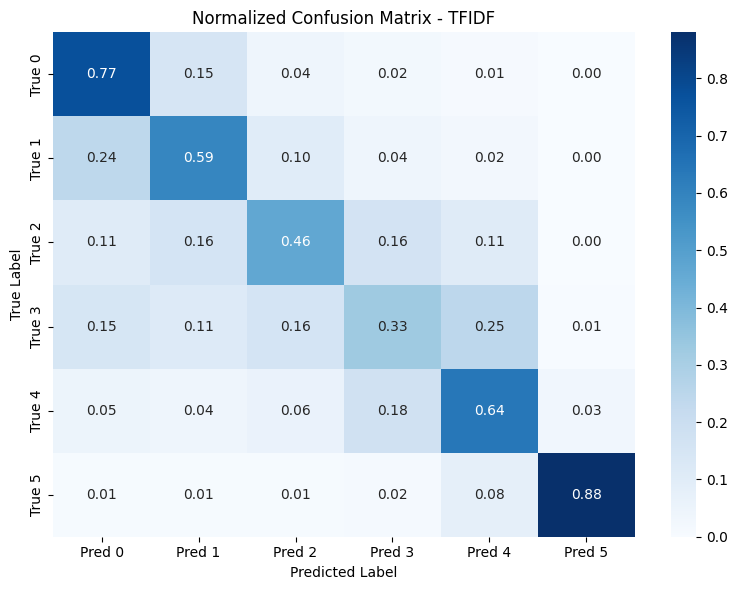


DETAILED RESULTS: WORD2VEC
Test Loss: 1.0005
Training Time: 0.93 minutes
Best Val Accuracy: 0.6014

Accuracy: 0.5875

Classification Report:
              precision    recall  f1-score   support

           0     0.5391    0.7789    0.6372      1547
           1     0.5320    0.5055    0.5184      1547
           2     0.4763    0.4292    0.4515      1547
           3     0.4568    0.2838    0.3501      1547
           4     0.5587    0.6613    0.6057      1547
           5     0.9633    0.8662    0.9122      1547

    accuracy                         0.5875      9282
   macro avg     0.5877    0.5875    0.5792      9282
weighted avg     0.5877    0.5875    0.5792      9282


Confusion Matrix (rows=true, cols=pred):
[[1205  222   80   22   18    0]
 [ 445  782  240   47   32    1]
 [ 244  242  664  213  182    2]
 [ 258  156  270  439  419    5]
 [  77   57  127  220 1023   43]
 [   6   11   13   20  157 1340]]

Quadratic Weighted Kappa (QWK): 0.8055
Top-2 Accuracy: 0.8028


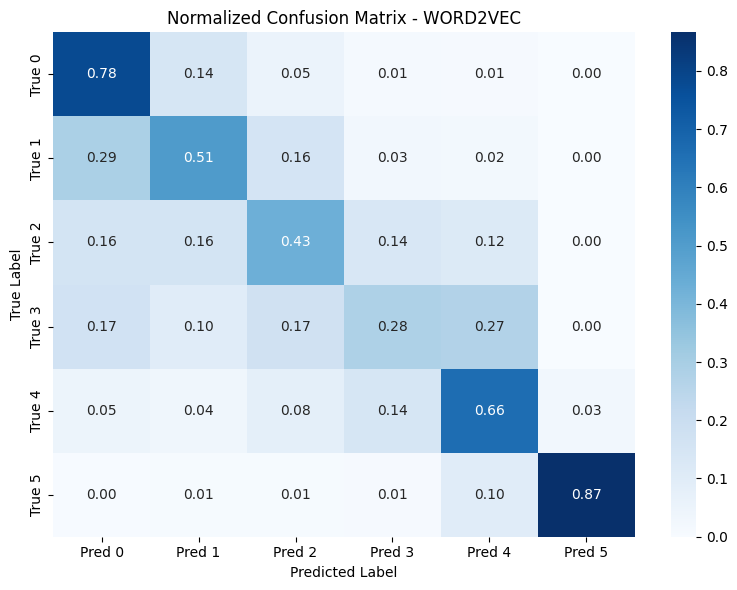


DETAILED RESULTS: ARABERT
Test Loss: 1.0035
Training Time: 13.52 minutes
Best Val Accuracy: 0.6765

Accuracy: 0.6724

Classification Report:
              precision    recall  f1-score   support

           0     0.7405    0.8151    0.7760      1547
           1     0.7253    0.7117    0.7184      1547
           2     0.5914    0.5501    0.5700      1547
           3     0.4464    0.4525    0.4494      1547
           4     0.5961    0.6354    0.6151      1547
           5     0.9573    0.8694    0.9112      1547

    accuracy                         0.6724      9282
   macro avg     0.6762    0.6724    0.6734      9282
weighted avg     0.6762    0.6724    0.6734      9282


Confusion Matrix (rows=true, cols=pred):
[[1261  107   79   91    9    0]
 [ 140 1101  150  134   22    0]
 [ 124  154  851  268  146    4]
 [ 138  109  263  700  332    5]
 [  39   43   90  341  983   51]
 [   1    4    6   34  157 1345]]

Quadratic Weighted Kappa (QWK): 0.8448
Top-2 Accuracy: 0.8467


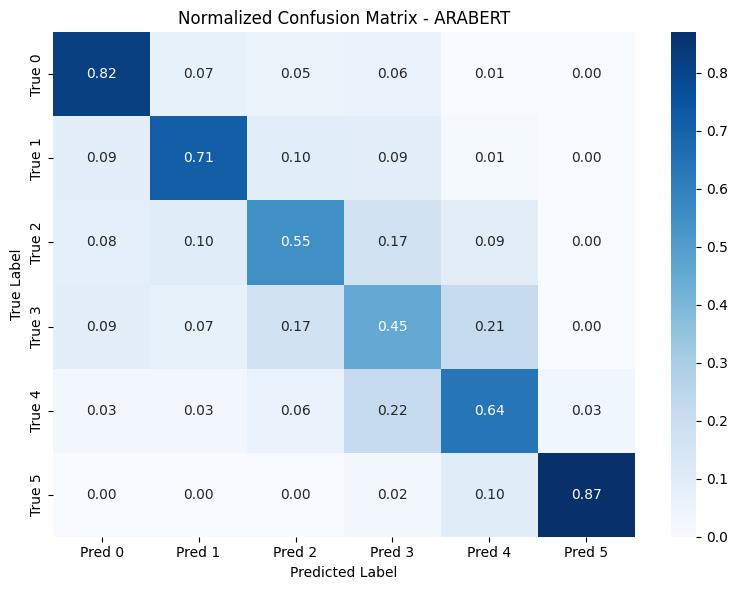


DETAILED RESULTS: CAMELBERT
Test Loss: 0.9155
Training Time: 12.45 minutes
Best Val Accuracy: 0.6943

Accuracy: 0.6935

Classification Report:
              precision    recall  f1-score   support

           0     0.7510    0.8384    0.7923      1547
           1     0.7291    0.7498    0.7393      1547
           2     0.6087    0.6044    0.6066      1547
           3     0.5088    0.4131    0.4559      1547
           4     0.6157    0.6639    0.6389      1547
           5     0.9169    0.8914    0.9040      1547

    accuracy                         0.6935      9282
   macro avg     0.6884    0.6935    0.6895      9282
weighted avg     0.6884    0.6935    0.6895      9282


Confusion Matrix (rows=true, cols=pred):
[[1297  121   53   70    6    0]
 [ 136 1160  162   72   17    0]
 [ 135  132  935  207  134    4]
 [ 133  130  294  639  340   11]
 [  25   43   88  254 1027  110]
 [   1    5    4   14  144 1379]]

Quadratic Weighted Kappa (QWK): 0.8646
Top-2 Accuracy: 0.8661


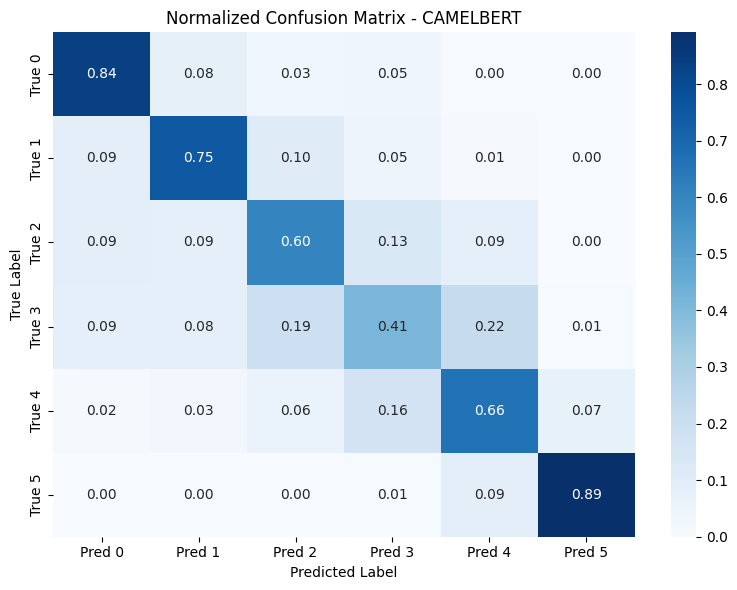

In [38]:
for emb_name, results in all_results.items():
    display_results(results, emb_name)

In [39]:
print("\n" + "="*70)
print("COMPARATIVE ANALYSIS - ALL EMBEDDING METHODS")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Embedding': [r['embedding'].upper() for r in all_results.values()],
    'Accuracy': [r['test_acc'] for r in all_results.values()],
    'QWK': [r['qwk'] for r in all_results.values()],
    'Top-2 Acc': [r['top2_acc'] for r in all_results.values()],
    'Test Loss': [r['test_loss'] for r in all_results.values()],
    'Training Time (min)': [r['training_time'] for r in all_results.values()]
})

print("\n" + comparison_df.to_string(index=False))
print("\n" + "="*70)

# Find best method
best_method = max(all_results.items(), key=lambda x: x[1]['test_acc'])
print(f"\nBEST PERFORMING METHOD: {best_method[0].upper()}")
print(f"   Accuracy: {best_method[1]['test_acc']:.4f}")
print(f"   QWK: {best_method[1]['qwk']:.4f}")

# Save comparison to CSV
comparison_df.to_csv(os.path.join(OUTPUT_DIR, "embedding_comparison.csv"), index=False)
print(f"\n✓ Comparison saved to: {OUTPUT_DIR}/embedding_comparison.csv")


COMPARATIVE ANALYSIS - ALL EMBEDDING METHODS

Embedding  Accuracy      QWK  Top-2 Acc  Test Loss  Training Time (min)
    TFIDF  0.612368 0.809548   0.811032   0.972628             1.230295
 WORD2VEC  0.587481 0.805493   0.802844   1.000483             0.931833
  ARABERT  0.672377 0.844782   0.846693   1.003506            13.521347
CAMELBERT  0.693493 0.864586   0.866085   0.915468            12.453153


BEST PERFORMING METHOD: CAMELBERT
   Accuracy: 0.6935
   QWK: 0.8646

✓ Comparison saved to: ./bilstm_comparison/embedding_comparison.csv
